### Models X2 | created 01/07/2022 | generalisation of Models X
> This notebook was created with the goal of the computational analysis of the spot properties output of the Opera.

##### Imports

In [137]:
# General
import os
import sys
import pickle
import random
import string
import numpy as np
import pandas as pd
from datetime import date
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

# Random Forest
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)] 
numpy 1.22.3 
pandas 1.4.2 
plotnine 0.8.0 
statsmodels 0.13.2 
sklearn 1.1.1


#### 1) Pre-Processing
This is the selection of the right columns from the Opera output file.

In [138]:
def opera_to_df(input, n_skip = 9):
    # Import Tab separated opera file
    raw_df = pd.read_csv(input, sep = '\t', skiprows = n_skip)       # Read file (txt or csv) and skip header
    #raw_df = raw_df.dropna(axis = dropaxis)                    # Remove non-value columns
    return raw_df 

def filter_frame(df, col_idx):
    df_out = df[df['Column'] == col_idx]    # Select Column
    return df_out

##### 2) Model Fitting

In [29]:
def attach_trc(df, path_annotations):
    ls_trc = []

    with open(path_annotations) as f:
        for line in f:
            ls_trc.append(int(line))
    df['trc'] = ls_trc

def get_rfc_model(df, features, prediction, estimators, depth_max):
    y = df[prediction]
    X = df[features]

    c = RandomForestClassifier(n_estimators = estimators, max_depth = depth_max)
    m_rfc = c.fit(X,y)

    p = m_rfc.predict(X)

    print(classification_report(y,p))
    ConfusionMatrixDisplay.from_predictions(y, p)

    return m_rfc

def store_rfc_model(model, path, name):
    # Identifier
    date_raw = date.today()
    d1 = date_raw.strftime("%d%m%y")

    identifier = d1 + "_" + name
    folderpath = os.path.join(path, identifier).replace("\\","/")
    os.mkdir(folderpath)

    descriptor =    str(model.feature_names_in_) + \
                    str(model.feature_importances_) + "\n" + \
                    "Features: " + str(model.n_features_) + "\n" + \
                    "Max Depth: " + str(model.max_depth)

    # Write Descriptor
    with open(folderpath + '/readme.txt', 'w') as f:
        f.write(descriptor)

    # Write Model
    pickle.dump(model, open(folderpath + f'/{identifier}.rfc', "wb"))


In [4]:
def getModel(input, rc, in_out):
    # 1) Obtain proper cuts
    df_clc = opera_to_df(in_out[0] + '/' + input)
    
    if len(rc) > 1:
        clc_pos = df_clc[df_clc['Row'] == rc[0]]
        clc_pos = df_clc[df_clc['Column'] == rc[1]]
    else:
        clc_pos = df_clc[df_clc['Column'] == rc[0]]

    # 2) Obtain Annotation Data
    attach_trc(clc_pos, in_out[0] + '/cep.txt')

    prediction = ['trc']
    features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

    m_rfc = get_rfc_model(clc_pos, features, prediction, estimators = 10, depth_max = 5)
    return m_rfc


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       162
           1       0.93      0.78      0.85        65

    accuracy                           0.92       227
   macro avg       0.92      0.88      0.90       227
weighted avg       0.92      0.92      0.92       227



C:\Users\Student\AppData\Local\Temp\ipykernel_10088\3768249418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_10088\3768249418.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\Users\Student\Desktop\LocalEnvs\localenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.


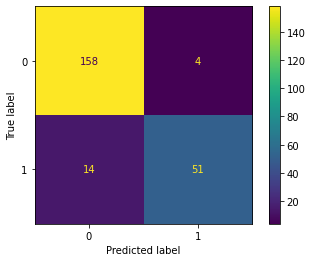

In [84]:
# MODEL GEN
in_out = ['data/0206_assay_novel/input_data', 'data/0206_assay_novel/output_data']
path = 'Objects_Population - coloc AR.txt'
model = getModel(path, [8], in_out)

store_rfc_model(model, in_out[1], 'prime')

In [32]:
features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

### Predictions | 1606 WT 1 | by 0206 prime
##### 1606 with 0206 prime

In [92]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_1 = ar_coloc_1606[ar_coloc_1606['Column'] == 4]

X = ar_wt_pos_1606_1[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_1['trc'] = trc_wt

ar_wt_pos_1606_1_view = ar_wt_pos_1606_1[ar_wt_pos_1606_1['trc'] == 1]
ar_wt_pos_1606_1_view.to_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

C:\Users\Student\AppData\Local\Temp\ipykernel_10088\2299552489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
ls_run_1 = []

with open('data/1606_assay_novel/output_data/ran_lab_0206_full_f100.txt', 'r') as f:
    for line in f:
        ls_run_1.append(int(line))

In [140]:
full_size = len(ls_run_1)
full_fold = ls_run_1.count(1) + ls_run_1.count(0)
positive_fold = ls_run_1.count(1)

print(f'Fold Positive Percentage: {positive_fold/full_fold * 100} %')
print(full_fold)

Fold Positive Percentage: 27.0 %
100


### Clustering

In [38]:
ar_wt_8_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

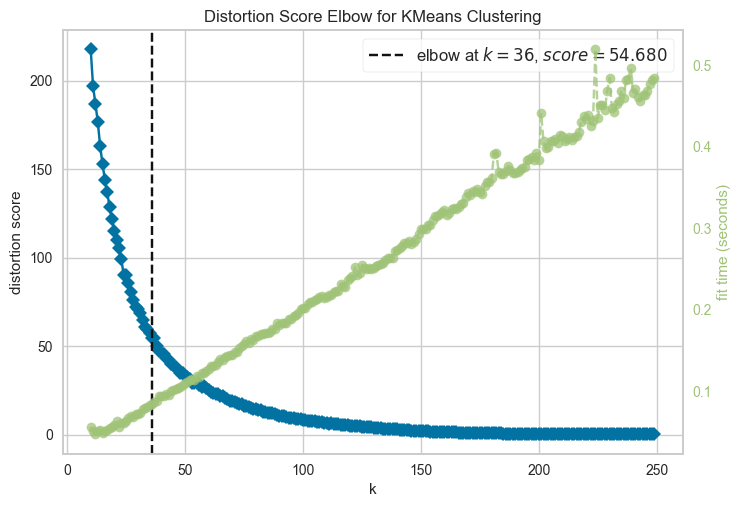

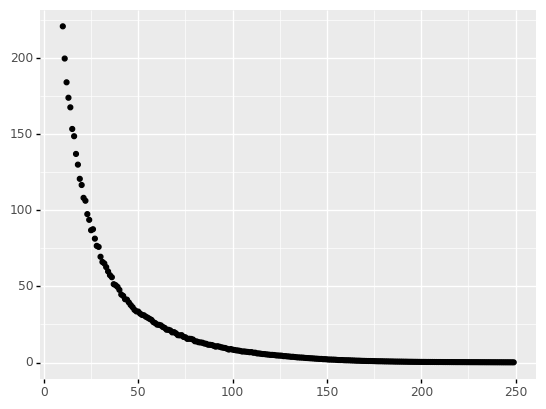

<ggplot: (178251193630)>

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer

X = ar_wt_8_view[['X', 'Y', 'Plane', 'Timepoint']]
X_scaled = StandardScaler().fit(X).transform(X)

K = range(10, 250)
withinSS = []

# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(10, 250))

# visualizer.fit(X_scaled)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

for k in K:
    m = KMeans(n_clusters = k).fit(X_scaled)
    withinSS.append(m.inertia_)

ggplot(aes(K, withinSS)) +\
    geom_point()

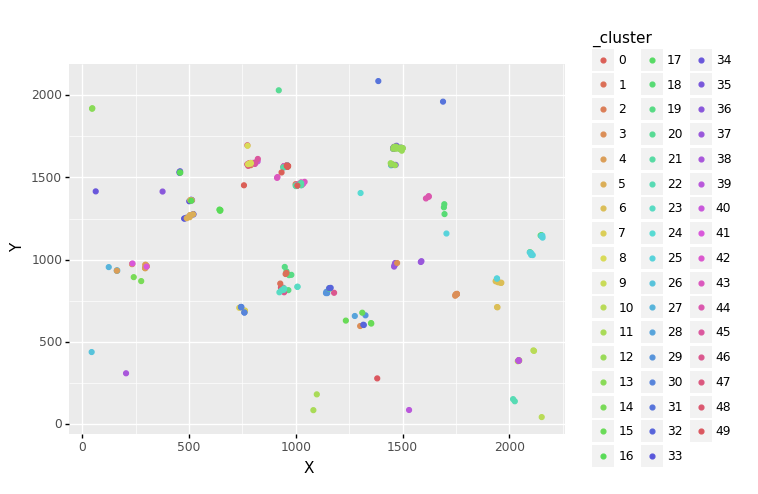

<ggplot: (178250255658)>

In [23]:
m = KMeans(n_clusters = 50).fit(X_scaled)
ar_wt_8_view['_cluster'] = pd.Categorical(m.labels_)

ggplot(ar_wt_8_view, aes('X', 'Y', color = '_cluster')) +\
    geom_point()

In [39]:
n_rows = ar_wt_8_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_8_view['cluster_id'] = empty_couples


In [28]:
ar_wt_8_view


,Unnamed: 0,Row,Column,Plane,Timepoint,Field,Object No,X,Y,Bounding Box,...,coloc AR - Uncorrected Spot Peak Intensity,coloc AR - Spot Contrast,coloc AR - Spot Background Intensity,coloc AR - Spot Area [px²],coloc AR - Region Intensity,coloc AR - Spot To Region Intensity,coloc AR - Object No in Nuclei Selected,coloc AR - Object No in Spots AR,trc,cluster_id
0,1,3,4,1,27,1,1,44,439,"[41,436,50,443]",...,749,0.067316,654.520000,58,544.098804,1.250882,4,4,1,0
1,7,3,4,2,38,1,1,2151,44,"[2146,40,2155,49]",...,733,0.069158,638.172414,79,629.833500,1.054187,8,6,1,0
2,39,3,4,3,61,2,2,1381,279,"[1377,276,1386,287]",...,1083,0.122693,846.290000,80,741.662000,1.219290,1,3,1,0
3,45,3,4,8,32,2,1,1705,1159,"[1699,1152,1709,1162]",...,1193,0.059017,1060.033333,64,845.394855,1.289006,4,3,1,0
4,46,3,4,9,36,2,1,1386,2085,"[1381,2080,1395,2093]",...,3336,0.330475,1678.750000,150,638.387495,3.408505,9,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,836,3,4,8,59,11,1,276,870,"[269,864,281,880]",...,908,0.206961,596.605263,124,437.317073,1.521171,3,2,1,0
309,840,3,4,9,26,11,3,235,977,"[228,973,240,980]",...,611,0.102533,497.357000,70,389.315000,1.339020,2,9,1,0
310,842,3,4,9,31,11,1,47,1920,"[39,1914,51,1930]",...,2023,0.095015,1671.925000,133,1368.671555,1.261879,4,3,1,0
311,843,3,4,9,32,11,1,46,1917,"[39,1912,51,1930]",...,2194,0.127473,1697.888889,173,1421.240730,1.280559,2,5,1,0


In [5]:
def dist(p1, p2):
    sp1, sp2 = np.array(p1[0:3]), np.array(p2[0:3])
    #print(f'SP1: {sp1}, SP2: {sp2}')
    sp_dist = np.linalg.norm(sp1 - sp2)
    
    tp1, tp2 = np.array(p1[3]), np.array(p2[3])
    tp_dist = np.linalg.norm(tp1 - tp2)
    return sp_dist, tp_dist

def buncher(df):
    at_id = 1   # Denotes the next available cluster id
    
    # 1) Go Across All Points
    for index, row in ar_wt_8_view.iterrows():
        ids_in_range = []   # Store all in same cluster
        current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

        # 2) Fetch all close to point
        for in_index, in_row in ar_wt_8_view.iterrows():
            if in_index != index:
                against = (in_row['X'], in_row['Y'], in_row['Plane'], in_row['Timepoint'])
                sp_dist, tp_dist = dist(current, against)

                if sp_dist < 10 and tp_dist < 2:
                    ids_in_range.append(in_index)

        curr_id = at_id

        # If already has cluster, use that cluster
        if ar_wt_8_view.at[index, 'cluster_id'] != 0:
            curr_id = ar_wt_8_view.at[index, 'cluster_id']

        # 3) Cluster current and all found
        ar_wt_8_view.at[index, 'cluster_id'] = curr_id
        for idx in ids_in_range:
            ar_wt_8_view.at[idx, 'cluster_id'] = curr_id
        
        at_id += 1      # Advance available cluster id
    
    # 4) Add Cluster Sizes
    ar_wt_8_view['cluster_size'] = ar_wt_8_view.groupby('cluster_id')['cluster_id'].transform('count')

    ls_bunch = []
    for x in range(20):
        bunch = (ar_wt_8_view.cluster_size >= x).sum()
        ls_bunch.append(bunch)
    return ls_bunch

def buncher_glx(df):
    at_id = 1   # Denotes the next available cluster id
    
    # 1) Go Across All Points
    for index, row in ar_wt_8_view.iterrows():
        ids_in_range = []   # Store all in same cluster
        current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

        # 2) Fetch all close to point
        for in_index, in_row in ar_wt_8_view.iterrows():
            if in_index != index:
                against = (in_row['X'], in_row['Y'], in_row['Plane'], in_row['Timepoint'])
                sp_dist, tp_dist = dist(current, against)

                if sp_dist < 10 and tp_dist < 2:
                    ids_in_range.append(in_index)

        # 3) Obtain ids_in_range subset that has clusters
        ls_idxs_to_remove = []
        ls_clusters_to_connect = []

        for idx in ids_in_range:
            if ar_wt_8_view.at[idx, 'cluster_id'] != 0:
                ls_idxs_to_remove.append(idx)
                ls_clusters_to_connect.append(ar_wt_8_view.at[idx, 'cluster_id'])

        ids_in_range = [x for x in ids_in_range if x not in ls_idxs_to_remove]

        curr_id = at_id

        # 3.1) Replace In Existent Clusters
        ar_wt_8_view['cluster_id'] = ar_wt_8_view['cluster_id'].replace(ls_clusters_to_connect, curr_id)

        # 3.2) Add to novel
        for idx in ids_in_range:
            ar_wt_8_view.at[idx, 'cluster_id'] = curr_id

        at_id += 1      # Advance available cluster id
    
    # 4) Add Cluster Sizes
    ar_wt_8_view['cluster_size'] = ar_wt_8_view.groupby('cluster_id')['cluster_id'].transform('count')

    ls_bunch = []
    for x in range(20):
        bunch = (ar_wt_8_view.cluster_size >= x).sum()
        ls_bunch.append(bunch)
    return ls_bunch


    # total, bunches = len(ar_wt_8_view), (ar_wt_8_view.cluster_size >= 3).sum()
    # print(total, bunches)


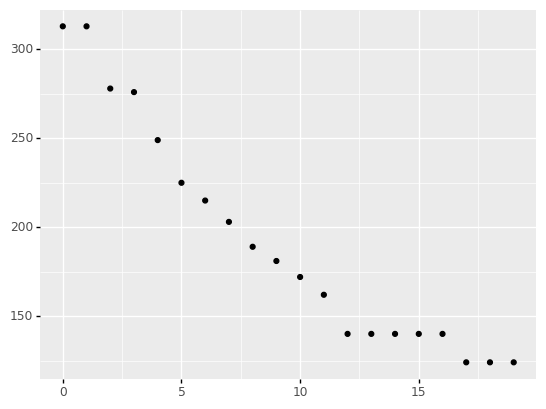

<ggplot: (132030520417)>

In [11]:
ar_wt_8_view = pd.read_csv('data/1606_assay_novel/output_data/ar_wt_4_view.csv')

n_rows = ar_wt_8_view.shape[0]

empty_couples = [0 for x in range(0, n_rows)]
ar_wt_8_view['cluster_id'] = empty_couples
ar_wt_8_view['cluster_size'] = empty_couples

ls_bunch = buncher_glx(ar_wt_8_view)

ggplot(aes(range(0, len(ls_bunch)), ls_bunch)) +\
    geom_point()


In [12]:
print(ls_bunch[4])

249


In [37]:
# GREEDY
at_id = 1

ctr = 0
snapshot = []

# Go across each row
for index, row in ar_wt_8_view.iterrows():
    if ctr > 10:
        break
    ctr += 1
    current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])
    # Check against each other row
    for a_index, a_row in ar_wt_8_view.iterrows():
        if a_index != index:
            against = (a_row['X'], a_row['Y'], a_row['Plane'], a_row['Timepoint'])
            # Get SPATIAL (SP) and TEMPORAL (TP) distance
            sp_dist, tp_dist = dist(current, against)

            if sp_dist < 10 and tp_dist < 2:
                # Case 1 | There was no annotation
                if row['cluster_id'] == 0 and a_row['cluster_id'] == 0:
                    ar_wt_8_view.at[index, 'cluster_id'] = at_id
                    ar_wt_8_view.at[a_index, 'cluster_id'] = at_id
                    at_id += 1
                    snapshot.append(ar_wt_8_view.copy())
                    print('de novo')
                # Case 2 | Current is not annotated
                elif row['cluster_id'] == 0 and a_row['cluster_id'] != 0:
                    ar_wt_8_view.at[index, 'cluster_id'] = ar_wt_8_view.at[a_index, 'cluster_id'] 
                    print('propell')
                # Case 3 | Both are annotated
                elif row['cluster_id'] != 0 and a_row['cluster_id'] != 0:
                    a_value = a_row['cluster_id']
                    ar_wt_8_view['cluster_id'].replace({a_value, 1})
                    print('reflex')

print(at_id)

de novo
de novo
de novo
4


In [71]:
# GREEDY EXPANSION
# FLAT: 3.7s
# FLAT + COMPARISONS: 6.4s
at_id = 1

for index, row in ar_wt_8_view.iterrows():
    ids_in_range = []   # Store all in same cluster
    current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

    for in_index, in_row in ar_wt_8_view.iterrows():
        if in_index != index:
            against = (in_row['X'], in_row['Y'], in_row['Plane'], in_row['Timepoint'])
            sp_dist, tp_dist = dist(current, against)

            if sp_dist < 10 and tp_dist < 2:
                ids_in_range.append(in_index)

    curr_id = at_id

    # Use Already present IF it is
    if ar_wt_8_view.at[index, 'cluster_id'] != 0:
        curr_id = ar_wt_8_view.at[index, 'cluster_id']

    ar_wt_8_view.at[index, 'cluster_id'] = curr_id
    for idx in ids_in_range:
        ar_wt_8_view.at[idx, 'cluster_id'] = curr_id
    
    at_id += 1
ar_wt_8_view['cluster_size'] = ar_wt_8_view.groupby('cluster_id')['cluster_id'].transform('count')

In [78]:
ar_coloc = ar_wt_8_view[ar_wt_8_view.cluster_id != 0]
print(len(ar_coloc['cluster_id']))
len(set(ar_coloc['cluster_id']))

np.bincount(np.array(ar_coloc['cluster_id']))

313


array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  0,  0,  0,  2,  0,
       10,  0,  0,  0,  0,  0,  0,  0,  0,  1,  3,  0,  1,  2,  2,  2,  0,
        1,  1,  0,  0,  0,  0,  1,  2,  2,  0,  0,  1,  5,  4,  2,  3,  0,
        0,  0,  0,  0,  5,  0,  0,  1,  0,  0,  6,  0,  0,  4,  0,  0,  0,
        0,  0,  3,  0,  0,  0,  0,  3,  1,  0,  0,  0,  0,  0,  0,  1,  4,
        0,  3,  8,  0,  0,  3,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  1,  1,  2,  0, 11,  0, 16,  0,  0,  7,  0, 11, 15,  7,
        0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  2,  1,  2,  0, 32,  0,  0,
        0, 16,  0,  3,  0,  0,  6,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

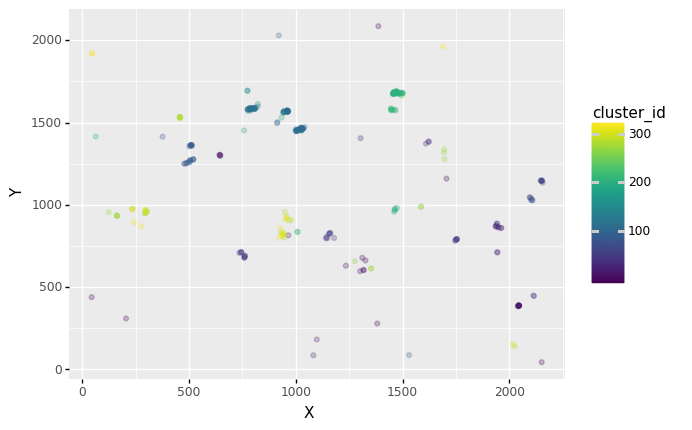

<ggplot: (143034212349)>

In [72]:
ggplot(ar_coloc, aes('X', 'Y', color = 'cluster_id')) +\
    geom_point(alpha = .25)

In [52]:
a = np.array((22, 44))
b = np.array((44, 56))
np.linalg.norm(a-b)

25.059928172283335

In [54]:
row = ar_wt_8_view.iloc[146]
current = (row['X'], row['Y'], row['Plane'], row['Timepoint'])

a_row = ar_wt_8_view.iloc[169]
a_current = (a_row['X'], a_row['Y'], a_row['Plane'], a_row['Timepoint'])

sp, tp = dist(current, a_current)
print(sp, tp)

SP1: [ 942 1563    5], SP2: [ 782 1584    6]
161.37533888422976 1.0


In [33]:
corell1, corell2, corell3 = snapshot[0], snapshot[1], snapshot[2]

### Nuclei

In [17]:
nuclei_1606_wt = opera_to_df('data/1606_assay_novel/input_data/nuclei.txt', n_skip = 8)

In [22]:
nuclei_1606_wt = filter_frame(nuclei_1606_wt, 8)
nuclei_1606_wt = nuclei_1606_wt.sort_values(by = ['Timepoint'])
nuclei_1606_wt['Nuclei - Ratio'] = nuclei_1606_wt['Nuclei Selected - Number of Objects'] / nuclei_1606_wt['Nuclei - Number of Objects']

mean_ratio = nuclei_1606_wt['Nuclei - Ratio'].mean()
mean_selected = nuclei_1606_wt['Nuclei Selected - Number of Objects'].mean()
print(f'Mean Ratio: {mean_ratio * 100} %, Mean Selected = {mean_selected}')

Mean Ratio: 22.665082061091294 %, Mean Selected = 41.758974358974356


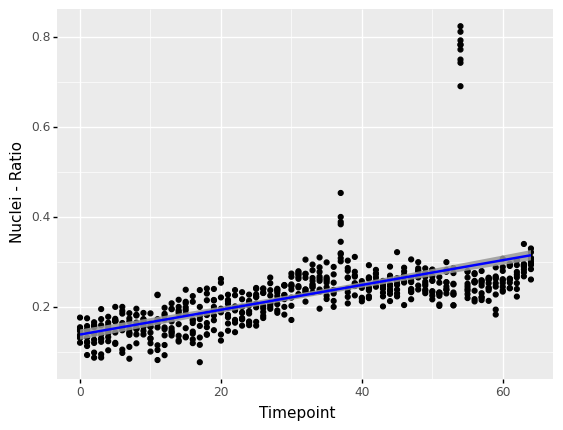

<ggplot: (143040391012)>

In [149]:
ggplot(nuclei_1606_wt, aes('Timepoint', 'Nuclei - Ratio')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

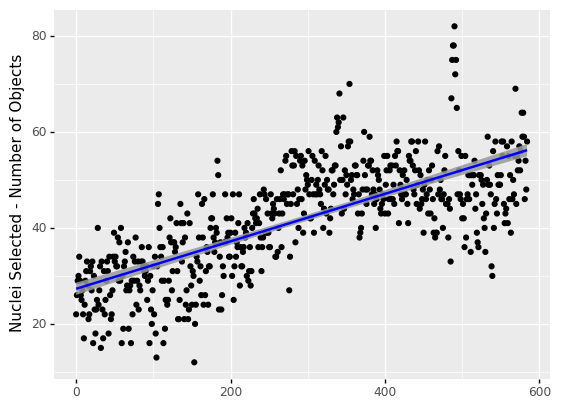

<ggplot: (132030669834)>

In [26]:
ggplot(nuclei_1606_wt, aes(range(0, len(nuclei_1606_wt)), 'Nuclei Selected - Number of Objects')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

In [30]:
ar_1606_full = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_1606_wt_4 = ar_1606_full[ar_1606_full['Column'] == 4]
ar_1606_wt_4.to_csv('data/1606_assay_novel/output_data/ar_wt_4_full.csv')

### Predictions | 1606 WT 2 | by 0206 prime

In [37]:
# LOAD model
model = pickle.load(open('data/0206_assay_novel/output_data/010722_prime/010722_prime.rfc', 'rb'))

# LOAD data
ar_coloc_1606 = opera_to_df('data/1606_assay/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_6 = ar_coloc_1606[ar_coloc_1606['Column'] == 6]
print(f'Initial: {len(ar_wt_pos_1606_6)}')

X = ar_wt_pos_1606_6[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_6['trc'] = trc_wt

ar_wt_pos_1606_6_view = ar_wt_pos_1606_6[ar_wt_pos_1606_6['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_6_view)}')
ar_wt_pos_1606_6_view.to_csv('data/1606_assay_novel/output_data/ar_wt_6_view.csv')

Initial: 964
Final: 337


C:\Users\acher\AppData\Local\Temp\ipykernel_12616\3952481903.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
